In [1]:
!pip install -q transformers accelerate scipy safetensors segments-ai
!pip install -q git+https://github.com/facebookresearch/segment-anything.git

%cd /content
!git clone --quiet https://github.com/IDEA-Research/Grounded-Segment-Anything
%cd /content/Grounded-Segment-Anything
!pip install -q -e /content/Grounded-Segment-Anything/GroundingDINO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
/content
/content/Grounded-Segment-Anything
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 31.8 MB/s eta 0:00:00


In [2]:
import os, sys

sys.path.append(
    os.path.join(os.getcwd(), "/content/Grounded-Segment-Anything/GroundingDINO")
)

In [3]:
import random
import requests

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from scipy import ndimage
from PIL import Image
from huggingface_hub import hf_hub_download
from segments import SegmentsClient
from segments.export import colorize
from segments.utils import bitmap2file
from getpass import getpass

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict
from GroundingDINO.groundingdino.util.inference import annotate, predict

# segment anything
from segment_anything import build_sam, SamPredictor

# CLIPSeg
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

if device != "cpu":
    try:
        from GroundingDINO.groundingdino import _C
    except:
        warnings.warn(
            "Failed to load custom C++ ops. Running on CPU mode Only in groundingdino!"
        )

Using device: cuda


In [5]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location="cpu")
    log = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    model.to(device)
    return model


# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filename = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

groundingdino_model = load_model_hf(
    ckpt_repo_id, ckpt_filename, ckpt_config_filename, device
)

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


In [6]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2023-04-25 13:19:47--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.162.20, 52.84.162.51, 52.84.162.103, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.162.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  53.2MB/s    in 21s     

2023-04-25 13:20:07 (118 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [7]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

In [8]:
clipseg_processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model = CLIPSegForImageSegmentation.from_pretrained(
    "CIDAS/clipseg-rd64-refined"
)
clipseg_model.to(device)

CLIPSegForImageSegmentation(
  (clip): CLIPSegModel(
    (text_model): CLIPSegTextTransformer(
      (embeddings): CLIPSegTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPSegEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPSegEncoderLayer(
            (self_attn): CLIPSegAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPSegMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=20

## Segments.ai stuff

In [9]:
api_key = getpass("Enter your API key: ")
segments_client = SegmentsClient(api_key)

Enter your API key: ··········


In [10]:
dataset_identifier = "youssefelhami/pizza-102"

samples = segments_client.get_samples(dataset_identifier)
dataset = segments_client.get_dataset(dataset_identifier)
categories = dataset.task_attributes.categories
category_name_to_id = {category.name: category.id for category in categories}

# split the categories into "stuff" categories (regions w/o instances)
# and "thing" categories (objects/instances)
stuff_categories = [category for category in categories if category.has_instances]
thing_categories = [category for category in categories if not category.has_instances]
stuff_category_names = [category.name for category in stuff_categories]
thing_category_names = [category.name for category in thing_categories]

print("Stuff categories", stuff_category_names)
print("Thing categories", thing_category_names)

Stuff categories []
Thing categories ['pizza']


In [11]:
def download_image(url):
    return Image.open(requests.get(url, stream=True).raw)


def load_image_for_dino(image):
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    dino_image, _ = transform(image, None)
    return dino_image


def dino_detection(
    model,
    image,
    image_array,
    category_names,
    category_name_to_id,
    box_threshold,
    text_threshold,
    device,
    visualize=False,
):
    detection_prompt = " . ".join(category_names)
    dino_image = load_image_for_dino(image)
    dino_image = dino_image.to(device)
    with torch.no_grad():
        boxes, logits, phrases = predict(
            model=model,
            image=dino_image,
            caption=detection_prompt,
            box_threshold=box_threshold,
            text_threshold=text_threshold,
            device=device,
        )
    category_ids = [category_name_to_id[phrase] for phrase in phrases]

    if visualize:
        annotated_frame = annotate(
            image_source=image_array, boxes=boxes, logits=logits, phrases=phrases
        )
        annotated_frame = annotated_frame[..., ::-1]  # BGR to RGB
        visualization = Image.fromarray(annotated_frame)
        return boxes, category_ids, visualization
    else:
        return boxes, category_ids, phrases


def sam_masks_from_dino_boxes(predictor, image_array, boxes, device):
    # box: normalized box xywh -> unnormalized xyxy
    H, W, _ = image_array.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
    transformed_boxes = predictor.transform.apply_boxes_torch(
        boxes_xyxy, image_array.shape[:2]
    ).to(device)
    thing_masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    return thing_masks


def preds_to_semantic_inds(preds, threshold):
    flat_preds = preds.reshape((preds.shape[0], -1))
    # Initialize a dummy "unlabeled" mask with the threshold
    flat_preds_with_treshold = torch.full(
        (preds.shape[0] + 1, flat_preds.shape[-1]), threshold
    )
    flat_preds_with_treshold[1 : preds.shape[0] + 1, :] = flat_preds

    # Get the top mask index for each pixel
    semantic_inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape(
        (preds.shape[-2], preds.shape[-1])
    )

    return semantic_inds


def clipseg_segmentation(
    processor, model, image, category_names, background_threshold, device
):
    inputs = processor(
        text=category_names,
        images=[image] * len(category_names),
        padding="max_length",
        return_tensors="pt",
    ).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    if len(logits.shape) == 2:
      logits = logits.unsqueeze(0)
    # resize the outputs
    upscaled_logits = nn.functional.interpolate(
        logits.unsqueeze(1),
        size=(image.size[1], image.size[0]),
        mode="bilinear",
    )
    preds = torch.sigmoid(upscaled_logits.squeeze(dim=1))
    semantic_inds = preds_to_semantic_inds(preds, background_threshold)
    return preds, semantic_inds


def semantic_inds_to_shrunken_bool_masks(
    semantic_inds, shrink_kernel_size, num_categories
):
    shrink_kernel = np.ones((shrink_kernel_size, shrink_kernel_size))

    bool_masks = torch.zeros((num_categories, *semantic_inds.shape), dtype=bool)
    for category in range(num_categories):
        binary_mask = semantic_inds == category
        shrunken_binary_mask_array = (
            ndimage.binary_erosion(binary_mask.numpy(), structure=shrink_kernel)
            if shrink_kernel_size > 0
            else binary_mask.numpy()
        )
        bool_masks[category] = torch.from_numpy(shrunken_binary_mask_array)

    return bool_masks


def clip_and_shrink_preds(semantic_inds, preds, shrink_kernel_size, num_categories):
    # convert semantic_inds to shrunken bool masks
    bool_masks = semantic_inds_to_shrunken_bool_masks(
        semantic_inds, shrink_kernel_size, num_categories
    ).to(preds.device)

    sizes = [
        torch.sum(bool_masks[i].int()).item() for i in range(1, bool_masks.size(0))
    ]
    max_size = max(sizes)
    relative_sizes = [size / max_size for size in sizes] if max_size > 0 else sizes

    # use bool masks to clip preds
    clipped_preds = torch.zeros_like(preds)
    for i in range(1, bool_masks.size(0)):
        float_mask = bool_masks[i].float()
        clipped_preds[i - 1] = preds[i - 1] * float_mask

    return clipped_preds, relative_sizes


def sample_points_based_on_preds(preds, N):
    height, width = preds.shape
    weights = preds.ravel()
    indices = np.arange(height * width)

    # Randomly sample N indices based on the weights
    sampled_indices = random.choices(indices, weights=weights, k=N)

    # Convert the sampled indices into (col, row) coordinates
    sampled_points = [(index % width, index // width) for index in sampled_indices]

    return sampled_points


def upsample_pred(pred, image_source):
    pred = pred.unsqueeze(dim=0)
    original_height = image_source.shape[0]
    original_width = image_source.shape[1]

    larger_dim = max(original_height, original_width)
    aspect_ratio = original_height / original_width

    # upsample the tensor to the larger dimension
    upsampled_tensor = F.interpolate(
        pred, size=(larger_dim, larger_dim), mode="bilinear", align_corners=False
    )

    # remove the padding (at the end) to get the original image resolution
    if original_height > original_width:
        target_width = int(upsampled_tensor.shape[3] * aspect_ratio)
        upsampled_tensor = upsampled_tensor[:, :, :, :target_width]
    else:
        target_height = int(upsampled_tensor.shape[2] * aspect_ratio)
        upsampled_tensor = upsampled_tensor[:, :, :target_height, :]
    return upsampled_tensor.squeeze(dim=1)


def sam_mask_from_points(predictor, image_array, points):
    points_array = np.array(points)
    # we only sample positive points, so labels are all 1
    points_labels = np.ones(len(points))
    # we don't use predict_torch here cause it didn't seem to work...
    masks, scores, logits = predictor.predict(
        point_coords=points_array,
        point_labels=points_labels,
    )
    # max over the 3 segmentation levels
    total_pred = torch.max(torch.sigmoid(torch.tensor(logits)), dim=0)[0].unsqueeze(
        dim=0
    )
    # logits are 256x256 -> upsample back to image shape
    upsampled_pred = upsample_pred(total_pred, image_array)
    return upsampled_pred

In [25]:
def generate_panoptic_mask(
    image,
    thing_category_names,
    stuff_category_names,
    category_name_to_id,
    dino_model,
    sam_predictor,
    clipseg_processor,
    clipseg_model,
    device,
    dino_box_threshold=0.45,
    dino_text_threshold=0.25,
    segmentation_background_threshold=0.1,
    shrink_kernel_size=20,
    num_samples_factor=1000,
):
    image = image.convert("RGB")
    image_array = np.asarray(image)

    # compute SAM image embedding
    sam_predictor.set_image(image_array)

    # detect boxes for "thing" categories using Grounding DINO
    thing_category_ids = []
    thing_masks = []
    thing_boxes = []
    if len(thing_category_names) > 0:
        thing_boxes, thing_category_ids, _ = dino_detection(
            dino_model,
            image,
            image_array,
            thing_category_names,
            category_name_to_id,
            dino_box_threshold,
            dino_text_threshold,
            device,
        )
        if len(thing_boxes) > 0:
            # get segmentation masks for the thing boxes
            thing_masks = sam_masks_from_dino_boxes(
                sam_predictor, image_array, thing_boxes, device
            )

    if len(stuff_category_names) > 0:
        # get rough segmentation masks for "stuff" categories using CLIPSeg
        clipseg_preds, clipseg_semantic_inds = clipseg_segmentation(
            clipseg_processor,
            clipseg_model,
            image,
            stuff_category_names,
            segmentation_background_threshold,
            device,
        )
        # remove things from stuff masks
        clipseg_semantic_inds_without_things = clipseg_semantic_inds.clone()
        if len(thing_boxes) > 0:
            combined_things_mask = torch.any(thing_masks, dim=0)
            clipseg_semantic_inds_without_things[combined_things_mask[0]] = 0
        # clip CLIPSeg preds based on non-overlapping semantic segmentation inds (+ optionally shrink the mask of each category)
        # also returns the relative size of each category
        clipsed_clipped_preds, relative_sizes = clip_and_shrink_preds(
            clipseg_semantic_inds_without_things,
            clipseg_preds,
            shrink_kernel_size,
            len(stuff_category_names) + 1,
        )
        # get finer segmentation masks for the "stuff" categories using SAM
        sam_preds = torch.zeros_like(clipsed_clipped_preds)
        for i in range(clipsed_clipped_preds.shape[0]):
            clipseg_pred = clipsed_clipped_preds[i]
            # for each "stuff" category, sample points in the rough segmentation mask
            num_samples = int(relative_sizes[i] * num_samples_factor)
            if num_samples == 0:
                continue
            points = sample_points_based_on_preds(
                clipseg_pred.cpu().numpy(), num_samples
            )
            if len(points) == 0:
                continue
            # use SAM to get mask for points
            pred = sam_mask_from_points(sam_predictor, image_array, points)
            sam_preds[i] = pred
        sam_semantic_inds = preds_to_semantic_inds(
            sam_preds, segmentation_background_threshold
        )

    # combine the thing inds and the stuff inds into panoptic inds
    panoptic_inds = (
        sam_semantic_inds.clone()
        if len(stuff_category_names) > 0
        else torch.zeros(image_array.shape[0], image_array.shape[1], dtype=torch.long)
    )
    ind = len(stuff_category_names) + 1
    for thing_mask in thing_masks:
        # overlay thing mask on panoptic inds
        panoptic_inds[thing_mask.squeeze(dim=0)] = ind
        ind += 1

    return panoptic_inds, thing_category_ids

In [38]:
sample = samples[3]
image_url = sample.attributes.image.url

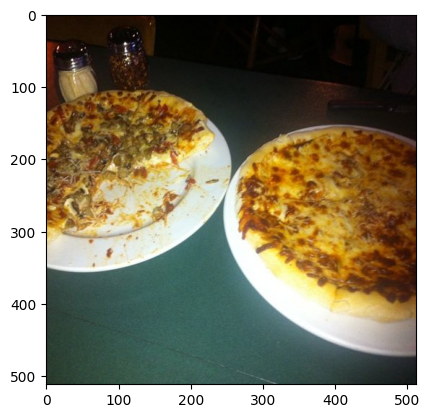

In [39]:
image = download_image(image_url)
plt.imshow(image)

In [40]:
panoptic_inds, thing_category_ids = generate_panoptic_mask(
    image,
    thing_category_names,
    stuff_category_names,
    category_name_to_id,
    groundingdino_model,
    sam_predictor,
    clipseg_processor,
    clipseg_model,
    device,
)

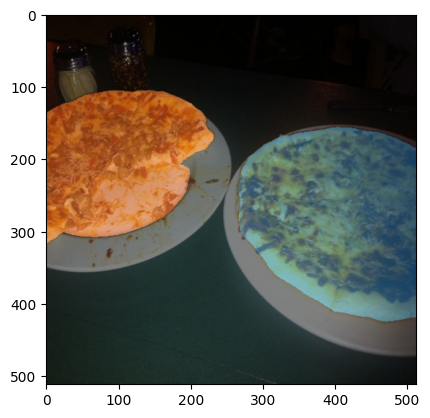

In [41]:
_, ax = plt.subplots()
ax.imshow(image)
ax.imshow(colorize(panoptic_inds), alpha=0.5)

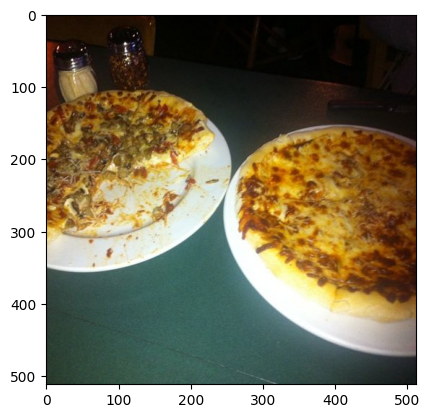

In [42]:
image = image.convert("RGB")
image_array = np.asarray(image)
plt.imshow(image_array)

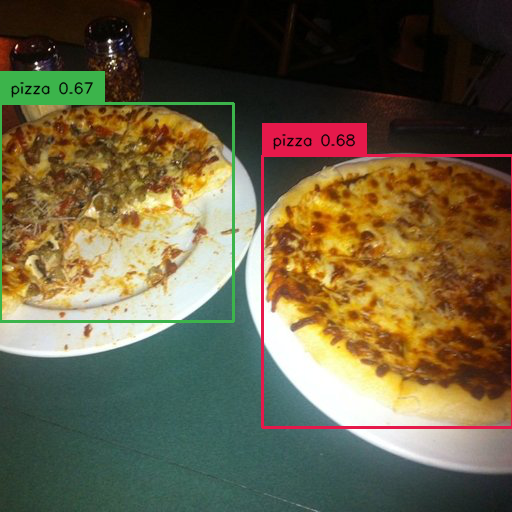

In [43]:
dino_box_threshold = 0.45
dino_text_threshold = 0.25

thing_boxes, thing_category_ids, visualization = dino_detection(
    groundingdino_model,
    image,
    image_array,
    thing_category_names,
    category_name_to_id,
    dino_box_threshold,
    dino_text_threshold,
    device,
    visualize=True,
)
visualization

In [45]:
def inds_to_segments_format(
    panoptic_inds, thing_category_ids, stuff_category_names, category_name_to_id
):
    panoptic_inds_array = panoptic_inds.numpy().astype(np.uint32)
    bitmap_file = bitmap2file(panoptic_inds_array, is_segmentation_bitmap=True)

    stuff_category_ids = [
        category_name_to_id[stuff_category_name]
        for stuff_category_name in stuff_category_names
    ]

    unique_inds = np.unique(panoptic_inds_array)
    stuff_annotations = [
        {"id": i, "category_id": stuff_category_ids[i - 1]}
        for i in range(1, len(stuff_category_names) + 1)
        if i in unique_inds
    ]
    thing_annotations = [
        {"id": len(stuff_category_names) + 1 + i, "category_id": thing_category_id}
        for i, thing_category_id in enumerate(thing_category_ids)
    ]
    annotations = stuff_annotations + thing_annotations

    return bitmap_file, annotations


def upload_label(
    panoptic_inds,
    thing_category_ids,
    stuff_category_names,
    category_name_to_id,
    segments_client,
    sample,
):
    bitmap_file, annotations = inds_to_segments_format(
        panoptic_inds, thing_category_ids, stuff_category_names, category_name_to_id
    )

    asset = segments_client.upload_asset(bitmap_file, "panoptic_sam_prediction.png")

    attributes = {
        "format_version": "0.1",
        "annotations": annotations,
        "segmentation_bitmap": {"url": asset.url},
    }

    segments_client.add_label(sample.uuid, "ground-truth", attributes)

In [46]:
upload_label(
    panoptic_inds,
    thing_category_ids,
    stuff_category_names,
    category_name_to_id,
    segments_client,
    sample,
)

In [ ]:
for sample in samples:
    image = download_image(sample.attributes.image.url)
    panoptic_inds, thing_category_ids = generate_panoptic_mask(
        image,
        thing_category_names,
        stuff_category_names,
        category_name_to_id,
        groundingdino_model,
        sam_predictor,
        clipseg_processor,
        clipseg_model,
        device,
    )
    upload_label(
        panoptic_inds,
        thing_category_ids,
        stuff_category_names,
        category_name_to_id,
        segments_client,
        sample,
    )